In [70]:
import pandas as pd
import numpy as np
import spacy
import nltk
import string
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

## Loading data

In [71]:
df = pd.read_csv('england_recent.csv')

## sample 10% of data, preprocess (lematization, no stopwords removal!)

In [72]:
from tqdm.notebook import tqdm
tqdm.pandas()

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")

# Sample 10% of the data 
df_sample = df.sample(frac=0.5, random_state=21).copy()
#df_sample = df.copy()

#only lematizing, want to keep as many words as possible. 
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    doc = nlp(text.lower())
    return " ".join(token.lemma_ for token in doc if not token.is_punct and not token.is_space)


# Apply preprocessing with progress bar
for col in ['pros', 'cons']:
    print(f"Processing column: {col}")
    df_sample[f'{col}_clean'] = df_sample[col].progress_apply(preprocess_text)

# Preview result
df_sample[['pros_clean', 'cons_clean']].head()

Processing column: pros


  0%|          | 0/63810 [00:00<?, ?it/s]

Processing column: cons


  0%|          | 0/63810 [00:00<?, ?it/s]

,pros_clean,cons_clean
73417,good environment free food flexible hour,night shift compulsory low pay
59426,invest heavily in you to get you promote,abandon you when contract be lose
10562,good company to work for,no downside to work here
50951,excellent salary colleague can be quite friend...,almost sexist mindset difficult to learn train...
88667,alright for a first job some supervisor be ver...,very low pay force to stand in one place for 8...


In [73]:
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

## Getting rid of the ultra long reviews as they are hard to tokenize

In [74]:
def is_too_long(text, max_tokens=300):
    try:
        prompt = f"Sentiment toward 'placeholder': {text.strip()}"
        tokens = tokenizer(prompt, return_tensors="pt", truncation=False)
        return tokens["input_ids"].shape[1] > max_tokens
    except:
        return True  # Skip anything that breaks

df_sample['too_long_pro'] = df_sample['pros'].apply(lambda x: is_too_long(x, max_tokens=300))
df_sample['too_long_con'] = df_sample['cons'].apply(lambda x: is_too_long(x, max_tokens=300))

# Filter them out
df_sample = df_sample[~(df_sample['too_long_pro'] | df_sample['too_long_con'])]


Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors


## Moving to ASBA analysis

In [75]:
def get_aspect_sentiment(text, aspect, tone):
    if pd.isnull(text):
        return None

    # Compose prompt-like input for aspect analysis
    if tone == 'pos':
        combined = f"The following is a positive experience about {aspect}: {text}"
    else:
        combined = f"The following is a negative experience about {aspect}: {text}"

    inputs = tokenizer(combined, return_tensors="pt", truncation=True, max_length=512)

    with torch.no_grad():
        logits = model(**inputs).logits
    scores = softmax(logits.numpy()[0])

    # This model returns scores for: [1 star, 2 stars, 3 stars, 4 stars, 5 stars]
    star_labels = [1, 2, 3, 4, 5]
    result = dict(zip(star_labels, scores))
    result["label"] = star_labels[scores.argmax()]
    return result


In [76]:
df_sample = df_sample[
    (df_sample['pros_clean'].str.strip() != '') & (df_sample['cons_clean'].str.strip() != '')
]
print("Empty pros_clean:", (df_sample['pros_clean'].str.strip() == '').sum())
print("Empty cons_clean:", (df_sample['cons_clean'].str.strip() == '').sum())


Empty pros_clean: 0
Empty cons_clean: 0


In [77]:
from collections import Counter
failed_sentiment = Counter()

def analyze_all_aspect_groups(text, aspect_groups, tone):
    results = {}
    for aspect, keywords in aspect_groups.items():
        if any(kw in text.lower() for kw in keywords):
            sent = get_aspect_sentiment(text, aspect, tone)
            if sent:
                results[aspect] = sent
            else:
                failed_sentiment[aspect] += 1  # Track failures
    return results


## Adding marie's dynamic aspect detection

In [78]:
from pyabsa import ATEPCCheckpointManager

# Load ABSA model
aspect_extractor = ATEPCCheckpointManager.get_aspect_extractor(
    checkpoint='english',
    auto_device=True
)

# Clean for ABSA
def clean_min(text):
    if not isinstance(text, str):
        return ""
    return text.replace('\n', ' ').replace('\r', '').encode("ascii", errors="ignore").decode().strip()

df_sample['min_prep_pros'] = df_sample['pros'].apply(clean_min)
df_sample['min_prep_cons'] = df_sample['cons'].apply(clean_min)

# Sample for ABSA (adjust size as needed)
texts_pros = df_sample['min_prep_pros'].dropna().sample(frac=0.2, random_state=42).tolist()
texts_cons = df_sample['min_prep_cons'].dropna().sample(frac=0.2, random_state=42).tolist()

# Extract aspects from pros and cons
absa_results_pros = aspect_extractor.extract_aspect(inference_source=texts_pros, print_result=False)
absa_results_cons = aspect_extractor.extract_aspect(inference_source=texts_cons, print_result=False)

# Collect discovered aspects
from collections import Counter

aspect_counter = Counter()
for result in absa_results_pros + absa_results_cons:
    for asp in result.get("aspect", []):
        aspect_counter[asp.lower()] += 1

# Show top discovered aspects
top_aspects = [asp for asp, count in aspect_counter.items() if count >= 3]
print(f"Top discovered aspects: {top_aspects}")


[2025-04-18 16:26:12] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-04-18 16:26:12] (2.4.1.post1) ********** Available ATEPC model checkpoints for Version:2.4.1.post1 (this version) **********
[2025-04-18 16:26:12] (2.4.1.post1) Downloading checkpoint:english 
[2025-04-18 16:26:12] (2.4.1.post1) Notice: The pretrained model are used for testing, it is recommended to train the model on your own custom datasets
[2025-04-18 16:26:12] (2.4.1.post1) Checkpoint already downloaded, skip
[2025-04-18 16:26:12] (2.4.1.post1) Load aspect extractor from checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43
[2025-04-18 16:26:12] (2.4.1.post1) config: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apcacc_82.36_apcf1_81.89_atef1_75.43/fast_lcf_atepc.config
[2025-04-18 16:26:12] (2.4.1.post1) state_dict: checkpoints/ATEPC_ENGLISH_CHECKPOINT/fast_lcf_atepc_English_cdw_apc

/opt/anaconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
classifying aspect sentiments: 100%|██████████| 534/534 [42:57<00:00,  4.83s/it]


[2025-04-18 17:37:48] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/monikakaczorowska/Desktop/glassdoor_reviews/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json


classifying aspect sentiments: 100%|██████████| 396/396 [30:59<00:00,  4.69s/it]


[2025-04-18 18:38:10] (2.4.1.post1) The results of aspect term extraction have been saved in /Users/monikakaczorowska/Desktop/glassdoor_reviews/Aspect Term Extraction and Polarity Classification.FAST_LCF_ATEPC.result.json
Top discovered aspects: ['restaurant', 'discount', 'staff', 'lunch', 'pay', 'offices', 'values', 'they', 'environment', 'location', 'colleagues', 'team', 'atmosphere', 'salary', 'benefits', 'flex', 'company', 'culture', 'people', 'training programme', 'employees', 'opportunities', 'purpose', 'pension scheme', 'benefits package', 'place', 'team environment', 'collegues', 'waiting', 'lunch break', 'training', 'managers', 'food', 'facilities', 'development', 'work', 'hr team', 'ceo', 'systems', 'management', 'job', 'infrastructure', 'bonus', 'mobility', 'hours', 'pension', 'ethos', 'stress', 'customers', 'holiday pay', 'progression', 'technologies', 'canteen', 'bar', 'stock', 'overtime', 'crew', 'research', 'gym', 'parking', 'projects', 'flexible working', 'rate', 'quali

In [79]:
top_aspects

['restaurant',
 'discount',
 'staff',
 'lunch',
 'pay',
 'offices',
 'values',
 'they',
 'environment',
 'location',
 'colleagues',
 'team',
 'atmosphere',
 'salary',
 'benefits',
 'flex',
 'company',
 'culture',
 'people',
 'training programme',
 'employees',
 'opportunities',
 'purpose',
 'pension scheme',
 'benefits package',
 'place',
 'team environment',
 'collegues',
 'waiting',
 'lunch break',
 'training',
 'managers',
 'food',
 'facilities',
 'development',
 'work',
 'hr team',
 'ceo',
 'systems',
 'management',
 'job',
 'infrastructure',
 'bonus',
 'mobility',
 'hours',
 'pension',
 'ethos',
 'stress',
 'customers',
 'holiday pay',
 'progression',
 'technologies',
 'canteen',
 'bar',
 'stock',
 'overtime',
 'crew',
 'research',
 'gym',
 'parking',
 'projects',
 'flexible working',
 'rate',
 'quality',
 'teams',
 'fruit',
 'tea',
 'coffee',
 'academy',
 'taught',
 'bank',
 'dress',
 'everyone',
 'pros',
 'money',
 'employer',
 'dress code',
 'holiday',
 'incentives',
 'scale',


In [80]:
from collections import Counter

# Combine pros and cons into one string per row
combined_texts = (
    df_sample['min_prep_pros'].fillna('') + ' ' + df_sample['min_prep_cons'].fillna('')
).str.lower()

# Count how many unique reviews mention each aspect
aspect_review_counts = {asp: combined_texts.str.contains(rf'\b{asp.lower()}\b').sum() for asp in top_aspects}

# Display sorted
print("\n🧾 Number of Reviews Mentioning Each Auto-Detected Aspect (Unique Mentions Only):")
for asp, count in sorted(aspect_review_counts.items(), key=lambda x: -x[1]):
    print(f"{asp:<15}: {count}")



🧾 Number of Reviews Mentioning Each Auto-Detected Aspect (Unique Mentions Only):
work           : 24822
good           : 23447
people         : 14241
management     : 11997
pay            : 11853
working        : 11437
hours          : 10935
staff          : 10465
it             : 10436
company        : 9423
team           : 7437
opportunities  : 6899
benefits       : 6888
they           : 6795
environment    : 6751
time           : 6587
job            : 6575
training       : 6150
flexible       : 6132
friendly       : 6008
life           : 5958
culture        : 5475
progression    : 4975
career         : 4971
managers       : 4945
salary         : 4930
balance        : 4879
place          : 4652
colleagues     : 4616
life balance   : 4419
support        : 3882
development    : 3299
discount       : 3247
business       : 3059
employees      : 3047
new            : 2969
experience     : 2945
customers      : 2938
office         : 2876
times          : 2549
opportunity    : 2450
flexibl

## Here we should go to manually add things to the list

In [81]:
aspect_groups = {
    "pay": ["pay", "salary", "compensation", "wage", "income", "bonus"],
    "management": ["management", "managers", "leadership", "boss", "supervisor"],
    "work-life balance": ["work-life balance", "balance", "working hours", "hours", "flexibility", "overtime", "holiday"],
    "growth": ["growth", "grow", "career", "promotion", "advancement", "development", "opportunity", "progress"],
    "stress & pressure": ["stress", "pressure", "burnout", "demanding", "high pressure", "overload", "long hours", "stressful"],
    "culture": ["culture", "environment", "atmosphere", "company culture", "values"],
    "diversity & inclusion": ["diversity", "inclusion", "equality", "equity", "inclusive", "minority", "belonging"],
    "travel": ["travel", "commute", "commuting", "relocation", "mobility"],
    "benefits": ["benefits", "perks", "healthcare", "insurance", "pension", "rewards", "gym", "lunch", "dental"],
    "remote work": ["remote", "work from home", "wfh", "home office", "hybrid", "telework"],
    "flexibility": ["flexible", "flexibility", "adjustable schedule", "shift", "adaptable"],
    "people": ["people", "colleagues", "collegues", "coworker", "coworkers", "community", "teammates"],
    "training & onboarding": ["training", "onboarding", "orientation", "new hire", "introduction", "induction"],
    "job role clarity": ["role", "responsibility", "job description", "tasks", "duties", "expectation", "scope"],
    "tools & resources": ["tools", "resources", "equipment", "software", "support", "access", "tech stack", "technology"],
    "performance feedback": ["feedback", "review", "appraisal", "evaluation", "performance", "supervision", "goals"],
    "job security": ["job security", "layoff", "firing", "termination", "redundancy", "stable job"],
    "teamwork & collaboration": ["team", "teamwork", "collaboration", "supportive", "helpful", "team spirit", "group"]
}
def safe_analyze(text, aspect_groups, tone):
    try:
        return analyze_all_aspect_groups(text, aspect_groups, tone)
    except Exception as e:
        print(f"Failed on: {repr(text)}\nError: {e}")
        return {}

# Modified ABSA to use grouped aspect synonyms

df_sample['Clean_pro_aspect_sentiments'] = df_sample['pros_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['Clean_con_aspect_sentiments'] = df_sample['cons_clean'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

df_sample['pro_aspect_sentiments'] = df_sample['pros'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='pos'))
df_sample['con_aspect_sentiments'] = df_sample['cons'].progress_apply(lambda x: analyze_all_aspect_groups(x, aspect_groups, tone='neg'))

  0%|          | 0/63177 [00:00<?, ?it/s]

  0%|          | 0/63177 [00:00<?, ?it/s]

  0%|          | 0/63177 [00:00<?, ?it/s]

  0%|          | 0/63177 [00:00<?, ?it/s]

Applying aspect group to uncleaned pros/cons worked better since it maintains more context

leaving both in df but should go with the non clean ones

In [82]:
# Full list of all aspect labels from your aspect_groups
all_aspects = list(aspect_groups.keys())
pro_counts= Counter()
con_counts = Counter()
pro_counts_clean = Counter()
con_counts_clean = Counter()

for row in df_sample['pro_aspect_sentiments'].dropna():
    pro_counts.update(row.keys())
for row in df_sample['con_aspect_sentiments'].dropna():
    con_counts.update(row.keys())

for row in df_sample['Clean_pro_aspect_sentiments'].dropna():
    pro_counts_clean.update(row.keys())
for row in df_sample['Clean_con_aspect_sentiments'].dropna():
    con_counts_clean.update(row.keys())


# Ensure all aspects appear, even if 0
pro_data = [(aspect, pro_counts.get(aspect, 0)) for aspect in all_aspects]
con_data = [(aspect, con_counts.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data.sort(key=lambda x: x[1])
con_data.sort(key=lambda x: x[1])

# Ensure all aspects appear, even if 0
pro_data_clean = [(aspect, pro_counts_clean.get(aspect, 0)) for aspect in all_aspects]
con_data_clean = [(aspect, con_counts_clean.get(aspect, 0)) for aspect in all_aspects]

# Sort by count
pro_data_clean.sort(key=lambda x: x[1])
con_data_clean.sort(key=lambda x: x[1])

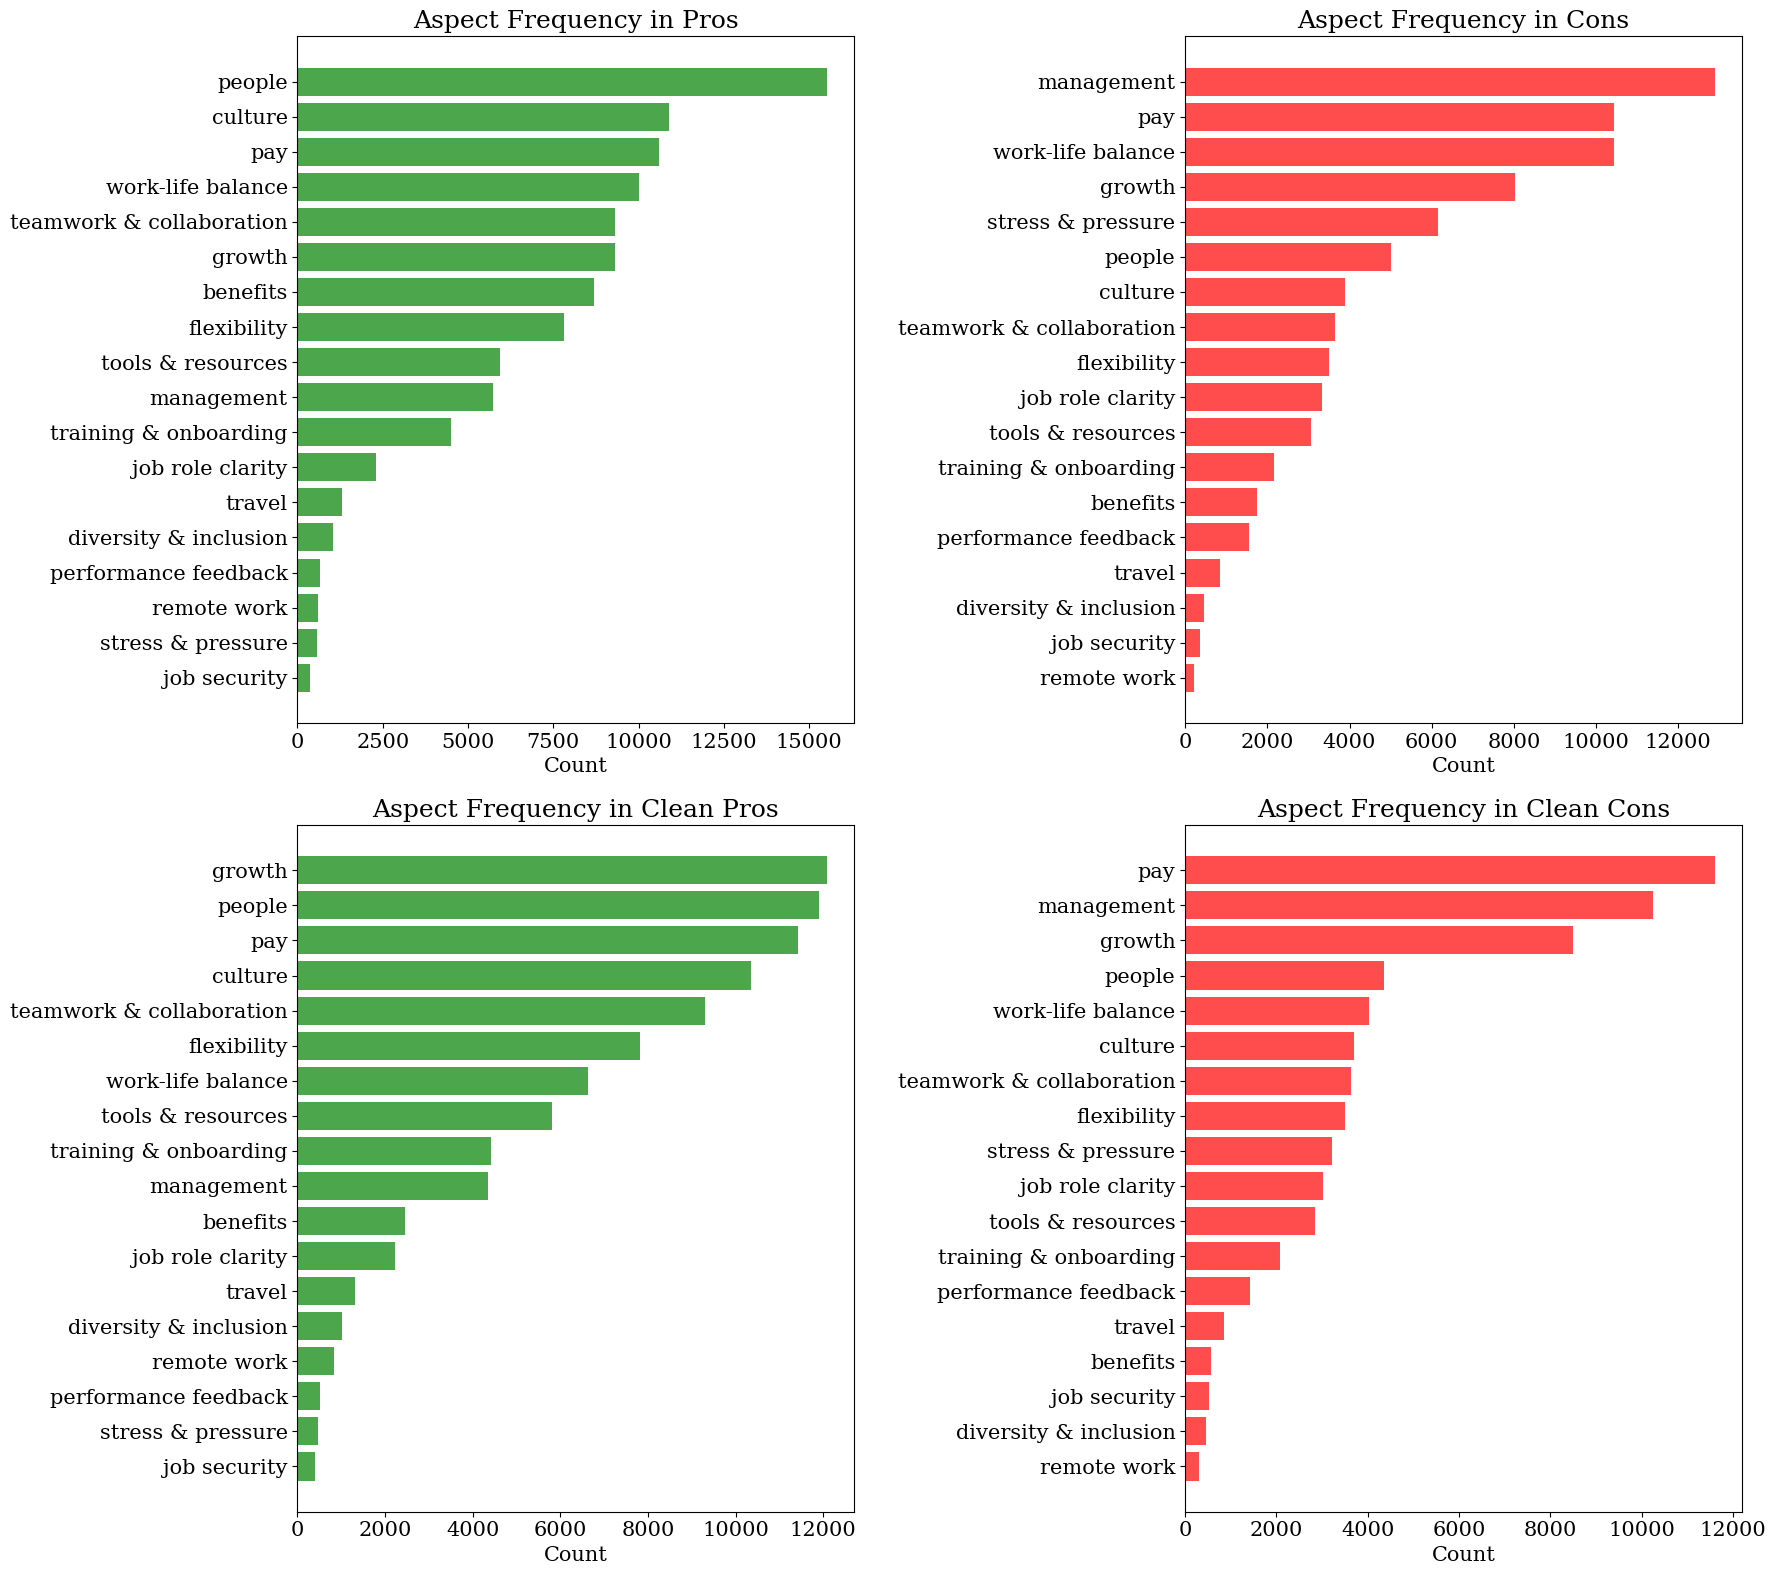

In [83]:
import matplotlib.pyplot as plt

# Prepare data (already done earlier)
# pro_data, con_data, pro_data_clean, con_data_clean assumed to be available

# Create 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(18, 16))  # Wider and taller figure for readability

# Plot 1: Pros
axs[0, 0].barh([a for a, c in pro_data], [c for a, c in pro_data], color='green', alpha=0.7)
axs[0, 0].set_title("Aspect Frequency in Pros")
axs[0, 0].set_xlabel("Count")

# Plot 2: Cons
axs[0, 1].barh([a for a, c in con_data], [c for a, c in con_data], color='red', alpha=0.7)
axs[0, 1].set_title("Aspect Frequency in Cons")
axs[0, 1].set_xlabel("Count")

# Plot 3: Clean Pros
axs[1, 0].barh([a for a, c in pro_data_clean], [c for a, c in pro_data_clean], color='green', alpha=0.7)
axs[1, 0].set_title("Aspect Frequency in Clean Pros")
axs[1, 0].set_xlabel("Count")

# Plot 4: Clean Cons
axs[1, 1].barh([a for a, c in con_data_clean], [c for a, c in con_data_clean], color='red', alpha=0.7)
axs[1, 1].set_title("Aspect Frequency in Clean Cons")
axs[1, 1].set_xlabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()


In [84]:
df_sample.to_csv('aspect_checsk.csv')

In [85]:
print("Uncleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts.get(aspect, 0)
    cons = con_counts.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Uncleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                             10594       10438
management                       5722       12898
work-life balance               10025       10429
growth                           9303        8036
stress & pressure                 560        6159
culture                         10895        3894
diversity & inclusion            1040         455
travel                           1303         854
benefits                         8695        1743
remote work                       606         212
flexibility                      7825        3502
people                          15533        5008
training & onboarding            4496        2158
job role clarity                 2310        3326
tools & resources                5949        3057
performance feedback              659        1544
job security                      378         362
teamwork & collaboration       

In [86]:
print("Cleaned counts:")
print(f"{'Aspect':<25}{'Pros Count':>12}{'Cons Count':>12}")
print("-" * 50)

for aspect in all_aspects:
    pros = pro_counts_clean.get(aspect, 0)
    cons = con_counts_clean.get(aspect, 0)
    print(f"{aspect:<25}{pros:>12}{cons:>12}")


Cleaned counts:
Aspect                     Pros Count  Cons Count
--------------------------------------------------
pay                             11430       11612
management                       4353       10247
work-life balance                6640        4017
growth                          12097        8505
stress & pressure                 464        3212
culture                         10362        3689
diversity & inclusion            1027         459
travel                           1303         854
benefits                         2448         567
remote work                       833         303
flexibility                      7825        3502
people                          11899        4361
training & onboarding            4423        2083
job role clarity                 2221        3026
tools & resources                5802        2841
performance feedback              525        1424
job security                      390         527
teamwork & collaboration         

## Aggregate the aspects per company

In [87]:
# 1–2. Flatten aspect sentiment results from pro + con columns
from collections import defaultdict

def flatten_aspect_sentiments(row, source):
    results = []
    firm = row.get('firm') or row.get('company')  # fallback
    sentiments = row.get(source, {})
    for aspect, scores in sentiments.items():
        # Aggregate actual star rating (1–5)
        rating = scores.get("label")
        all_stars = {i: scores.get(i, 0.0) for i in range(1, 6)}

        results.append({
            "firm": firm,
            "aspect": aspect,
            "source": source.replace('_aspect_sentiments', ''),  # 'pro' or 'con'
            "star_rating": rating,
            **all_stars
        })
    return results

# 3. Apply to full dataset
flattened = []
for _, row in df_sample.iterrows():
    flattened += flatten_aspect_sentiments(row, 'pro_aspect_sentiments')
    flattened += flatten_aspect_sentiments(row, 'con_aspect_sentiments')

flat_df = pd.DataFrame(flattened)

# 4. Aggregate star ratings + count mentions per company/aspect
company_aspect_matrix = flat_df.groupby(['firm', 'aspect'])['star_rating'].agg(
    avg_star_rating='mean',
    n_mentions='count'
).reset_index()
company_aspect_pivot = company_aspect_matrix.pivot(
    index='firm',
    columns='aspect',
    values='avg_star_rating'
)


# 6. Export
company_aspect_matrix.to_csv('company_aspect_matrix_with_counts.csv', index=False)
company_aspect_pivot.to_csv('company_aspect_matrix_wide.csv', index=False)


In [88]:
company_aspect_matrix

,firm,aspect,avg_star_rating,n_mentions
0,AFH-Wealth-Management,benefits,3.000000,2
1,AFH-Wealth-Management,culture,4.500000,2
2,AFH-Wealth-Management,flexibility,2.500000,2
3,AFH-Wealth-Management,growth,3.500000,4
4,AFH-Wealth-Management,job role clarity,1.000000,2
...,...,...,...,...
6187,the-LEGO-Group,stress & pressure,1.000000,1
6188,the-LEGO-Group,teamwork & collaboration,3.545455,11
6189,the-LEGO-Group,tools & resources,4.000000,6
6190,the-LEGO-Group,training & onboarding,2.750000,4


In [89]:
company_aspect_pivot

aspect,benefits,culture,diversity & inclusion,flexibility,growth,job role clarity,job security,management,pay,people,performance feedback,remote work,stress & pressure,teamwork & collaboration,tools & resources,training & onboarding,travel,work-life balance
firm,,,,,,,,,,,,,,,,,,
AFH-Wealth-Management,3.000000,4.500000,NaN,2.500000,3.500000,1.000000,NaN,2.222222,1.833333,3.454545,2.500000,NaN,4.000000,2.714286,2.000000,2.000000,NaN,3.250000
AJ-Bell,2.769231,3.700000,1.000000,3.333333,3.818182,1.666667,NaN,3.125000,2.600000,3.350000,NaN,NaN,2.000000,3.916667,4.090909,4.571429,NaN,3.333333
ALDI,3.925926,3.204082,2.500000,2.720930,2.802817,2.909091,4.0,1.861386,3.907489,3.185185,2.428571,NaN,1.575758,3.619048,2.625000,2.272727,1.666667,2.444444
AQA,3.857143,3.500000,2.000000,4.166667,3.300000,3.400000,1.5,2.583333,3.000000,3.687500,1.000000,NaN,1.500000,3.250000,3.000000,4.500000,NaN,3.923077
ASDA,3.407767,3.383459,3.666667,3.173759,2.738806,2.514286,3.0,1.902381,2.966921,3.203160,2.117647,3.2,1.656250,3.662162,2.693333,2.646154,2.000000,2.668142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
i-Net-Solution,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ibis,2.500000,2.500000,NaN,2.333333,3.666667,NaN,NaN,2.200000,2.500000,4.500000,NaN,NaN,NaN,2.800000,4.000000,1.000000,NaN,1.000000
mydentist-UK,3.333333,NaN,NaN,3.666667,2.625000,2.500000,NaN,2.000000,1.600000,3.333333,NaN,NaN,NaN,3.571429,2.900000,3.400000,NaN,3.000000
